## Part 1. Sequence Tagging: NER

### 1.1 Word Embedding

In [3]:
pip install seqeval

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [4]:
import gensim.downloader

In [5]:
# Downloading pretrained word2vec embeddings
w2v = gensim.downloader.load('word2vec-google-news-300')

In [6]:
# Querying the vector of a word
w2v['computer']

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

#### Question 1.1
##### Based on word2vec embeddings you have downloaded, use cosine similarity to find the most similar word to each of these words: (a)“student”; (b)“Apple”; (c)“apple”. Report the most similar word and its cosine similarity.

In [271]:
# Finding most similar words
words = ['student', 'Apple', 'apple']
similarWords = {}

for word in words:
    mostSimilar = w2v.most_similar(word, topn = 1)
    similarWords[word] = mostSimilar

# Print the results
for word, similar in similarWords.items():
    print(f"Word: {word}")
    for similar_word, cosine_similarity in similar:
        print(f"  Similar Word: {similar_word}, Cosine Similarity: {cosine_similarity:.4f}")

Word: student
  Similar Word: students, Cosine Similarity: 0.7295
Word: Apple
  Similar Word: Apple_AAPL, Cosine Similarity: 0.7457
Word: apple
  Similar Word: apples, Cosine Similarity: 0.7204


### 1.2 Data

In [9]:
def load_dataset(file_path):
    with open(file_path, 'r') as file:
        data = file.read()
    return data

# Load the training data
trainData = load_dataset('data/eng.train')

# Load the development data
devData = load_dataset('data/eng.testa')

# Load the test data
testData = load_dataset('data/eng.testb')

#### Question 1.2a
##### Describe the size (number of sentences) of the training, development and test file for CoNLL2003.

In [272]:
def count_sentences(data):
    # Split the data into sentences based on newline characters
    sentences = data.strip().split('\n\n')
    return len(sentences)

# Count the sentences in each dataset
trainSentenceCount = count_sentences(trainData)
devSentenceCount = count_sentences(devData)
testSentenceCount = count_sentences(testData)

# Print the counts
print(f"Number of Sentences in Training Data: {trainSentenceCount}")
print(f"Number of Sentences in Development Data: {devSentenceCount}")
print(f"Number of Sentences in Test Data: {testSentenceCount}")

Number of Sentences in Training Data: 14987
Number of Sentences in Development Data: 3466
Number of Sentences in Test Data: 3684


Specify the complete set of all possible word labels based on the tagging scheme (IO, BIO,
etc.) you chose.

In [273]:
def extract_labels(data):
    labels = set()
    sentences = data.strip().split('\n\n')
    
    for sentence in sentences:
        lines = sentence.split('\n')
        for line in lines:
            # Split each line by whitespace to extract label
            label = line.split()[-1]
            labels.add(label)
    
    return labels

# Extract labels from the training data
train_labels = extract_labels(trainData)

# Print the set of labels
print("Set of Word Labels:")
for label in train_labels:
    print(label)


Set of Word Labels:
O
B-MISC
B-LOC
I-PER
I-LOC
I-ORG
B-ORG
I-MISC


#### Question 1.2b
##### Choose an example sentence from the training set of CoNLL2003 that has at least two named entities with more than one word...

In [274]:
# Looking for sentences with >= 2 examples of entities that are made up of more than 1 word

# Returns a dictionary where key is the sentence, and its corresponding value is (1)the number of such entities found and (2)a list of these entities
def retrieveNamedEntities(data):
    # Split the data into sentences based on newline characters
    dataDict = {}
    sentences = data.strip().split('\n\n')
    for sentence in sentences:
        prevLabel = ""
        keySentence = []
        namedEntities = []
        namedEntityWords = []
        consecutiveCounter = 0
        namedEntityCounter = 0
        words = sentence.split('\n')

        for word in words:
            wordTags = word.split(' ')
            wordName = wordTags[0]
            wordLabel = wordTags[-1]
            keySentence.append(wordName)

            consecutiveCounter, namedEntityCounter, namedEntityWords, namedEntities = helper(wordLabel, prevLabel, wordName, consecutiveCounter, namedEntityCounter, namedEntityWords, namedEntities)

            # Keep track of the previous word label
            prevLabel = wordLabel

        # Use the complete sentence as the dictionary key for the number of named entities in the sentence, and the named entities itself
        key = ' '.join(keySentence)
        dataDict[key] = [namedEntityCounter, namedEntities]
    return dataDict


# Helper function to check for word label patterns corresponding to named entities (with more than 1 word)
def helper(label: str, prevLabel: str, wordName: str, consecutiveCounter: int, namedEntityCounter: int, namedEntityWords: list, namedEntities: list):

    # First word of a sentence or consecutive same "B-" type labels
    if consecutiveCounter == 0 or (label.split('-')[0] == 'B' and label == prevLabel):
        consecutiveCounter = 1

    # Current "I-" type label same as previous "I" -type label
    elif prevLabel == label:
        consecutiveCounter += 1

    # Current label is an "I-"type label and the previous label is a "B-" type label of the same kind
    elif label.split('-')[0] == 'I' and prevLabel.split('-')[0] == 'B' and label.split('-')[1] == prevLabel.split('-')[1]:
        consecutiveCounter += 1

    else:

        # namedEntityWords has more than 1 word
        if consecutiveCounter > 1:

            # Reset namedEntityWords if it contains a word with an "O" word label
            # Otherwise, it is a named entity
            if (prevLabel != 'O'):
                namedEntity = ' '.join(namedEntityWords)
                namedEntities.append(namedEntity)
                namedEntityCounter += 1
        consecutiveCounter = 1
        namedEntityWords = []
    namedEntityWords.append(wordName)
    return consecutiveCounter, namedEntityCounter, namedEntityWords, namedEntities


# countNamedEntities(train_data).items()
result = retrieveNamedEntities(trainData).items()
count = 0
for key, value in result:
    if value[0] > 1:
        count += 1
        print()
        print(key)
        print(value)

print (count)


Germany 's representative to the European Union 's veterinary committee Werner Zwingmann said on Wednesday consumers should buy sheepmeat from countries other than Britain until the scientific advice was clearer .
[2, ['European Union', 'Werner Zwingmann']]

" What we have to be extremely careful of is how other countries are going to take Germany 's lead , " Welsh National Farmers ' Union ( NFU ) chairman John Lloyd Jones said on BBC radio .
[3, ["Welsh National Farmers ' Union", 'John Lloyd Jones', 'BBC radio']]

China on Thursday accused Taipei of spoiling the atmosphere for a resumption of talks across the Taiwan Strait with a visit to Ukraine by Taiwanese Vice President Lien Chan this week that infuriated Beijing .
[2, ['Taiwan Strait', 'Lien Chan']]

Speaking only hours after Chinese state media said the time was right to engage in political talks with Taiwan , Foreign Ministry spokesman Shen Guofang told Reuters : " The necessary atmosphere for the opening of the talks has been

##### ...Explain how to form complete named entities from the label for each word, and list all the named entities in this sentence.


A named entity with more than one word would have consecutive "I-" tags of the same entity type.

Otherwise, word labels could also start with a "B-" tag, followed by consecutive "I-" tags, all of which are of the same entity type.

For example:

In [275]:
for key, value in result:
    if value[0] > 1:
        print("Sentence:\n", key)
        print()
        print("Named entities (with more than one word) in this sentence:")
        for namedEntity in value[1]:
            print("", namedEntity)
        break

Sentence:
 Germany 's representative to the European Union 's veterinary committee Werner Zwingmann said on Wednesday consumers should buy sheepmeat from countries other than Britain until the scientific advice was clearer .

Named entities (with more than one word) in this sentence:
 European Union
 Werner Zwingmann


In [292]:
for key, value in result:
    if "French Roman Catholic" in key:
        print("Sentence:\n", key)
        print()
        print("Named entities (with more than one word) in this sentence:")
        for namedEntity in value[1]:
            print("", namedEntity)
        break

Sentence:
 The television , which did not say when the security forces killed the rebels , said the four arrested men confessed details of the assassination of the French Roman Catholic Bishop Pierre Claverie .

Named entities (with more than one word) in this sentence:
 Roman Catholic
 Pierre Claverie


1. "European" and "Union" has the tags I-ORG, I-ORG.

2. "Werner" and "Zwingmann" has the tags I-PER, I-PER.

### Question 1.3
Now with the pretrained word embeddings acquired from Section 1.1, and the CoNLL2003 dataset acquired from Section 1.2, you need to train an NER model using the training set.

In [14]:
# import all required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# For neural network models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

# Using seqeval as evaluation metrics
from seqeval.metrics import f1_score
from seqeval.metrics import accuracy_score

# To calculate run time
import time

# For hyperparameter tuning
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import random

/Users/saniyanangia/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [15]:
def set_seed(seed = 0):
    '''
    set random seed
    '''
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(0)

##### Create dataframes with words from the train, validation and test data, and their corresponding labels and vectors

In [16]:
def max_sentence_length(data1, data2, data3):
    sentences0 = data1.strip().split('\n\n')
    sentences1 = data2.strip().split('\n\n')
    sentences2 = data3.strip().split('\n\n')

    max_length = 0

    for i in range(3):
        sentences_df = locals()["sentences" + str(i)]
        curr_length = max(len(sentence.split('\n')) for sentence in sentences_df)
        max_length = max(max_length, curr_length)
    
    return max_length

max_length = max_sentence_length(trainData, devData, testData)
print(max_length)

124


In [17]:
import numpy as np
import pandas as pd

def createDataFrame(data, max_length):
    sentences = data.strip().split('\n\n')
    max_length = max_length
    # print("Max sentence length = ", max_length)
    
    word_entries = []
    label_entries = []
    sentence_ids = []
    vector_data = []
    word_index = []
    sentence_lengths = []
    current_index = 0
    sentence_id = 0

    for sentence in sentences:
        lines = sentence.split('\n')
        sentence_lengths.append(len(lines))

        for line in lines:
            word, word_label = line.split(' ')[0], line.split(' ')[-1]
            word_entries.append(word)
            label_entries.append(word_label)
            sentence_ids.append(sentence_id)
            
            vector = w2v.get_vector(word) if word in w2v else np.random.rand(w2v.vector_size)
            vector_data.append(vector)
            
            word_index.append(current_index)
            current_index += 1
            
        sentence_id += 1
        current_index = 0
    
    # Create the DataFrame
    df = pd.DataFrame({
        'word': word_entries,
        'label': label_entries,
        'sentence_id': sentence_ids,
        'vector': vector_data,
        'word_index': word_index
    })
    
    # Create padding DataFrame
    padding_needed = max_length * len(sentences) - len(df)
    padding_df = pd.DataFrame({
        'word': ['<PAD>'] * padding_needed,
        'label': ['<PAD>'] * padding_needed,
        'sentence_id': sum([[i] * (max_length - len(rows)) for i, rows in df.groupby('sentence_id')], []),
        'vector': [np.full((w2v.vector_size,), 0)] * padding_needed
    })
    padding_indices = sum([[j for j in range(len(rows), max_length)] for i, rows in df.groupby('sentence_id')], [])
    padding_df['word_index'] = padding_indices  # Add the padding indices
    
    # Concatenate the padding DataFrame
    df = pd.concat([df, padding_df]).sort_values(by=['sentence_id', 'word_index']).reset_index(drop=True)
    
    return df, max_length

In [18]:
train_df, train_max_len = createDataFrame(trainData, max_length)
print(train_max_len)
train_df

124


,word,label,sentence_id,vector,word_index
0,EU,I-ORG,0,"[0.037353516, -0.203125, 0.21289062, 0.2441406...",0
1,rejects,O,0,"[0.00982666, 0.2265625, 0.28125, -0.36132812, ...",1
2,German,I-MISC,0,"[0.30664062, 0.11035156, 0.16699219, 0.0132446...",2
3,call,O,0,"[-0.11816406, 0.08154297, 0.15039062, 0.031005...",3
4,to,O,0,"[0.5488135039273248, 0.7151893663724195, 0.602...",4
...,...,...,...,...,...
1858383,<PAD>,<PAD>,14986,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",119
1858384,<PAD>,<PAD>,14986,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",120
1858385,<PAD>,<PAD>,14986,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",121
1858386,<PAD>,<PAD>,14986,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",122


In [19]:
dev_df, dev_max_len = createDataFrame(devData, max_length)
print(dev_max_len)
dev_df

124


,word,label,sentence_id,vector,word_index
0,CRICKET,O,0,"[-0.053222656, -0.2421875, 0.33398438, -0.0849...",0
1,-,O,0,"[0.2806834077738849, 0.4913860068848551, 0.384...",1
2,LEICESTERSHIRE,I-ORG,0,"[-0.09472656, -0.05102539, -0.020263672, -0.01...",2
3,TAKE,O,0,"[-0.10839844, -0.30859375, -0.0019989014, 0.37...",3
4,OVER,O,0,"[0.024414062, -0.40429688, 0.42773438, -0.0225...",4
...,...,...,...,...,...
429779,<PAD>,<PAD>,3465,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",119
429780,<PAD>,<PAD>,3465,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",120
429781,<PAD>,<PAD>,3465,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",121
429782,<PAD>,<PAD>,3465,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",122


In [20]:
test_df, test_max_len = createDataFrame(testData, max_length)
print(test_max_len)
test_df

124


,word,label,sentence_id,vector,word_index
0,SOCCER,O,0,"[0.12695312, 0.026000977, 0.26953125, -0.13281...",0
1,-,O,0,"[0.3082570586503306, 0.044480799809624716, 0.2...",1
2,JAPAN,I-LOC,0,"[0.17773438, 0.20996094, 0.21679688, 0.2988281...",2
3,GET,O,0,"[-0.045166016, -0.13769531, -0.0079956055, 0.1...",3
4,LUCKY,O,0,"[-0.013183594, -0.2421875, 0.060791016, 0.0654...",4
...,...,...,...,...,...
456811,<PAD>,<PAD>,3683,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",119
456812,<PAD>,<PAD>,3683,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",120
456813,<PAD>,<PAD>,3683,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",121
456814,<PAD>,<PAD>,3683,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",122


In [21]:
# Find unique labels in datasets
print(train_df['label'].unique())
print(dev_df['label'].unique())
print(test_df['label'].unique())

['I-ORG' 'O' 'I-MISC' '<PAD>' 'I-PER' 'I-LOC' 'B-LOC' 'B-MISC' 'B-ORG']
['O' 'I-ORG' '<PAD>' 'I-LOC' 'I-MISC' 'I-PER' 'B-MISC']
['O' 'I-LOC' 'I-PER' '<PAD>' 'I-MISC' 'I-ORG' 'B-ORG' 'B-MISC' 'B-LOC']


In [22]:
# list of labels
unique_labels = list((set(train_df['label'].unique()) | 
                      set(dev_df['label'].unique()) | 
                      set(test_df['label'].unique())) - {'<PAD>'})

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit the label encoder to list of labels
label_encoder.fit(unique_labels)

label_to_encoded = {label: index+1 for index, label in enumerate(label_encoder.classes_)}

# Manually add the '<PAD>' label with an encoded value of 0
label_to_encoded['<PAD>'] = 0

# Function to encode labels, with special handling for '<PAD>'
def encode_labels(column):
    return [label_to_encoded[label] for label in column]

# Transform labels into numerical values with special handling for <PAD>
train_df['label_encoded'] = encode_labels(train_df['label'])
dev_df['label_encoded'] = encode_labels(dev_df['label'])
test_df['label_encoded'] = encode_labels(test_df['label'])

print(unique_labels)

['O', 'B-MISC', 'B-LOC', 'I-PER', 'I-LOC', 'I-ORG', 'B-ORG', 'I-MISC']


In [23]:
train_df.head(20)

,word,label,sentence_id,vector,word_index,label_encoded
0,EU,I-ORG,0,"[0.037353516, -0.203125, 0.21289062, 0.2441406...",0,6
1,rejects,O,0,"[0.00982666, 0.2265625, 0.28125, -0.36132812, ...",1,8
2,German,I-MISC,0,"[0.30664062, 0.11035156, 0.16699219, 0.0132446...",2,5
3,call,O,0,"[-0.11816406, 0.08154297, 0.15039062, 0.031005...",3,8
4,to,O,0,"[0.5488135039273248, 0.7151893663724195, 0.602...",4,8
5,boycott,O,0,"[-0.04272461, 0.08203125, 0.12207031, -0.00037...",5,8
6,British,I-MISC,0,"[-0.06542969, -0.020385742, 0.014526367, 0.081...",6,5
7,lamb,O,0,"[-0.080078125, 0.15625, -0.35351562, 0.2216796...",7,8
8,.,O,0,"[0.906555499221179, 0.7740473326986388, 0.3331...",8,8
9,<PAD>,<PAD>,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9,0


In [24]:
print(train_df['label_encoded'].unique())
print(dev_df['label_encoded'].unique())
print(test_df['label_encoded'].unique())

[6 8 5 0 7 4 1 2 3]
[8 6 0 4 5 7 2]
[8 4 7 0 5 6 3 2 1]


In [25]:
# Final dfs to be used for training and testing
print(train_df)
print(dev_df)
print(test_df)

            word   label  sentence_id  \
0             EU   I-ORG            0   
1        rejects       O            0   
2         German  I-MISC            0   
3           call       O            0   
4             to       O            0   
...          ...     ...          ...   
1858383    <PAD>   <PAD>        14986   
1858384    <PAD>   <PAD>        14986   
1858385    <PAD>   <PAD>        14986   
1858386    <PAD>   <PAD>        14986   
1858387    <PAD>   <PAD>        14986   

                                                    vector  word_index  \
0        [0.037353516, -0.203125, 0.21289062, 0.2441406...           0   
1        [0.00982666, 0.2265625, 0.28125, -0.36132812, ...           1   
2        [0.30664062, 0.11035156, 0.16699219, 0.0132446...           2   
3        [-0.11816406, 0.08154297, 0.15039062, 0.031005...           3   
4        [0.5488135039273248, 0.7151893663724195, 0.602...           4   
...                                                    ...     

##### Defining Early Stopper

In [26]:
# Define early stopper to prevent overfitting (using f1 score as determinant)
class EarlyStopper:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.max_f1_score = -1.0

    def early_stop(self, f1_score):
        if f1_score > self.max_f1_score:
            self.max_f1_score = f1_score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

##### Defining Dataloaders

In [27]:
# Define a custom dataset class to load data
class CustomDataset(Dataset):
    def __init__(self, df):
        self.data = df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        vector = torch.tensor(self.data.iloc[idx]['vector'], dtype=torch.float32)
        label = torch.tensor(self.data.iloc[idx]['label_encoded'], dtype=torch.long)
        return vector, label

# Create a DataLoader for custom dataset
# Batch_size to go through hyperparameter tuning
# shuffle=False to not mess up entities
number_of_sentences = 2
custom_dataset_train = CustomDataset(train_df)
train_loader = DataLoader(custom_dataset_train, batch_size=number_of_sentences * train_max_len, shuffle=False)

custom_dataset_dev = CustomDataset(dev_df)
dev_loader = DataLoader(custom_dataset_dev, batch_size=number_of_sentences * dev_max_len, shuffle=False)

In [28]:
print(train_loader.batch_size)
print(dev_loader.batch_size)

248
248


##### Function to decode labels

In [29]:
# Inverse mapping from encoded value to label
encoded_to_label = {encoded: label for label, encoded in label_to_encoded.items()}

# Function to decode labels, with special handling for '<PAD>'
def decode_labels(label_tensor):
    return [encoded_to_label[int(encoded)] for encoded in label_tensor]

print(encoded_to_label)

{1: 'B-LOC', 2: 'B-MISC', 3: 'B-ORG', 4: 'I-LOC', 5: 'I-MISC', 6: 'I-ORG', 7: 'I-PER', 8: 'O', 0: '<PAD>'}


In [279]:
#testing padding mask
for vectors, labels in train_loader:  
    label_mask = labels != 0
    filtered_labels = labels[label_mask]
    
    vector_mask = (vectors != 0).all(dim=1)
    filtered_vectors = vectors[vector_mask]
    print(vectors)
    print(filtered_vectors)
    break

tensor([[ 0.0374, -0.2031,  0.2129,  ...,  0.1572,  0.2598, -0.0588],
        [ 0.0098,  0.2266,  0.2812,  ...,  0.0306, -0.1035,  0.2031],
        [ 0.3066,  0.1104,  0.1670,  ...,  0.1289,  0.0074, -0.1133],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])
tensor([[ 0.0374, -0.2031,  0.2129,  ...,  0.1572,  0.2598, -0.0588],
        [ 0.0098,  0.2266,  0.2812,  ...,  0.0306, -0.1035,  0.2031],
        [ 0.3066,  0.1104,  0.1670,  ...,  0.1289,  0.0074, -0.1133],
        ...,
        [-0.1387,  0.0437, -0.1309,  ...,  0.0825,  0.2295,  0.0593],
        [-0.1196, -0.0209, -0.1367,  ..., -0.0422, -0.0422, -0.1055],
        [ 0.7704,  0.3801,  0.6222,  ...,  0.1295,  0.0154,  0.3867]])


##### Function to plot training loss, accuracy and f1 score

In [31]:
import matplotlib.pyplot as plt

def plot_metrics(epoch_accuracy, epoch_f1, epoch_loss):
    num_of_ran_epochs = list(range(1, len(epoch_accuracy) + 1))
    
    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(num_of_ran_epochs, epoch_accuracy, marker='o', linestyle='-')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

    # Plot F1 Score
    plt.figure(figsize=(10, 5))
    plt.plot(num_of_ran_epochs, epoch_f1, marker='o', linestyle='-')
    plt.title('F1 Score vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.grid(True)
    plt.show()

    # Plot Loss
    plt.figure(figsize=(10, 5))
    plt.plot(num_of_ran_epochs, epoch_loss, marker='o', linestyle='-')
    plt.title('Valid Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()


### Single Linear Network Model

In [32]:
# Define a Single Layer NN model
class SingleLinearNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SingleLinearNetwork, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.fc(x)
        return x

In [290]:
model = SingleLinearNetwork(300, 9)

total_params = sum(param.numel() for param in model.parameters())
print(total_params)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

2709
2709
fc.weight torch.Size([9, 300])
fc.bias torch.Size([9])


In [40]:
# Define model's input dimension and output dimension
input_dim = w2v.vector_size
output_dim = len(unique_labels) + 1 # (pad)
print("Size of input: ", input_dim)
print("Size of output: ", output_dim)

# Instantiate SLN Model
sln_model = SingleLinearNetwork(input_dim, output_dim)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(sln_model.parameters(), lr=0.001)
num_epochs = 50

#Early Stopping
ES = EarlyStopper(patience = 10)

# Track run time of model training
start_time = time.time()

# Training loop
print("Starting model training...")
num_batches = len(train_loader)
epoch_accuracy = []
epoch_loss = []
epoch_f1 = []
for epoch in range(num_epochs):
    sln_model.train()
    train_loss = 0
    for vectors, labels in train_loader:
        # zeroing out <PAD>
        label_mask = labels != 0
        filtered_labels = labels[label_mask]

        vector_mask = (vectors != 0).all(dim=1)
        filtered_vectors = vectors[vector_mask]

        optimizer.zero_grad()
        outputs = sln_model(filtered_vectors)

        # Calculate loss
        loss = loss_fn(outputs, filtered_labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= num_batches

    # Evaluate on the development set
    val_loss = 0
    val_accuracy = []
    f1_score_val = []
    num_val_batches = len(dev_loader)
    size = len(dev_loader.dataset)
    sln_model.eval()
    with torch.no_grad():
        for X, y in dev_loader:
            label_mask = y != 0
            filtered_y = y[label_mask]

            vector_mask = (X != 0).all(dim=1)
            filtered_X = X[vector_mask]

            val_outputs = sln_model(filtered_X)
            val_outputs = F.softmax(val_outputs, dim=1)  # Apply softmax activation
            y_val_pred_classes = np.argmax(val_outputs, axis=1)

            # Transform y back to labels to use in seqeval metrics
            y_true = [decode_labels(filtered_y)]

            # Transform predicted classes back to labels to use in seqeval metrics
            y_pred = [decode_labels(y_val_pred_classes)]

            # Calculate accuracy, f1_score and loss
            val_accuracy.append(accuracy_score(y_true, y_pred))
            f1_score_val.append(f1_score(y_true, y_pred, average = "weighted", zero_division = 0))
            val_loss += loss_fn(val_outputs, filtered_y)

    val_accuracy = np.mean(val_accuracy)
    f1_score_val = np.mean(f1_score_val)
    val_loss /= num_val_batches
    
    epoch_accuracy.append(val_accuracy)
    epoch_f1.append(f1_score_val)
    epoch_loss.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy * 100:.2f}%, F1 Score: {f1_score_val: 4f}')

    if ES.early_stop(f1_score_val):
        print(f"No improvement in F1 score for {ES.patience} epochs. Stopping training.")
        break

end_time = time.time()
run_time = end_time - start_time
print(f"Run time: {run_time: .4f}s")

Size of input:  300
Size of output:  9
Starting model training...
Epoch 1/50, Train Loss: 0.3634, Val Loss: 1.4833, Val Accuracy: 92.91%, F1 Score:  0.583539
Epoch 2/50, Train Loss: 0.2710, Val Loss: 1.4736, Val Accuracy: 93.31%, F1 Score:  0.593717
Epoch 3/50, Train Loss: 0.2632, Val Loss: 1.4704, Val Accuracy: 93.43%, F1 Score:  0.604645
Epoch 4/50, Train Loss: 0.2597, Val Loss: 1.4689, Val Accuracy: 93.66%, F1 Score:  0.611426
Epoch 5/50, Train Loss: 0.2579, Val Loss: 1.4680, Val Accuracy: 93.68%, F1 Score:  0.613817
Epoch 6/50, Train Loss: 0.2568, Val Loss: 1.4674, Val Accuracy: 93.71%, F1 Score:  0.617176
Epoch 7/50, Train Loss: 0.2561, Val Loss: 1.4670, Val Accuracy: 93.68%, F1 Score:  0.617771
Epoch 8/50, Train Loss: 0.2556, Val Loss: 1.4667, Val Accuracy: 93.67%, F1 Score:  0.617727
Epoch 9/50, Train Loss: 0.2553, Val Loss: 1.4665, Val Accuracy: 93.67%, F1 Score:  0.619322
Epoch 10/50, Train Loss: 0.2551, Val Loss: 1.4663, Val Accuracy: 93.68%, F1 Score:  0.619613
Epoch 11/50, 

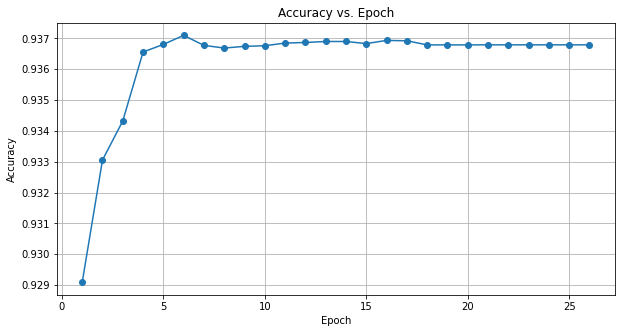

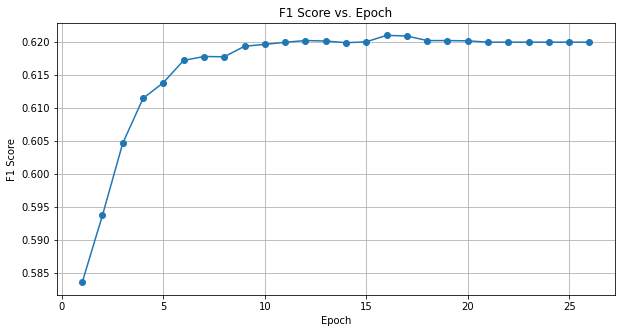

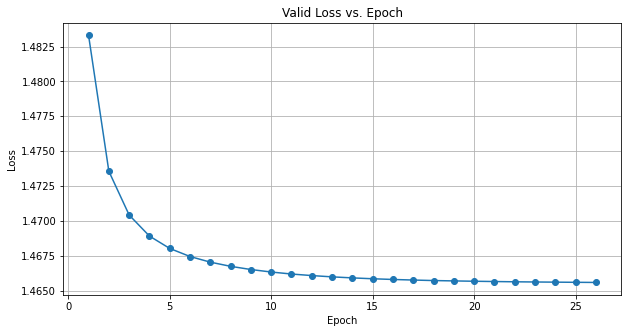

In [41]:
plot_metrics(epoch_accuracy, epoch_f1, epoch_loss)

#### Evaluating SLN model on test set

In [122]:
# Classifying words in test set and evaluating results
X_test = torch.tensor(test_df['vector'], dtype = torch.float32)
y_test = torch.tensor(test_df['label_encoded'], dtype = torch.long)

sln_model.eval()
with torch.no_grad():
    label_mask = y_test != 0
    y_test = y_test[label_mask]
    vector_mask = (X_test != 0).all(dim=1)
    X_test = X_test[vector_mask]
    pred = sln_model(X_test)

probabilities = F.softmax(pred, dim=1)
predicted_class = torch.argmax(pred, dim=1)
print(f"Predicted class: {predicted_class}")
print(f"True class: {y_test}")

log_probabilities = F.log_softmax(pred, dim=1)
loss = -log_probabilities.gather(1, y_test.view(-1, 1))
test_loss = loss.mean().item()
print(f"Test loss: {test_loss}")

y_true = decode_labels(y_test)
y_true = [y_true]

y_pred = decode_labels(predicted_class)
y_pred = [y_pred]

f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1}")

accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Predicted class: tensor([8, 8, 4,  ..., 7, 8, 8])
True class: tensor([8, 8, 4,  ..., 7, 8, 8])
Test loss: 0.2511696219444275
F1 Score: 0.6253233967733652
Test Accuracy: 94.07%


### LSTM (RNN) Model

In [33]:
# Define a LSTM NN model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        logits = self.fc(out)
        return logits

In [291]:
model = LSTMClassifier(300, 128, 9)

total_params = sum(param.numel() for param in model.parameters())
print(total_params)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

221321
221321
lstm.weight_ih_l0 torch.Size([512, 300])
lstm.weight_hh_l0 torch.Size([512, 128])
lstm.bias_ih_l0 torch.Size([512])
lstm.bias_hh_l0 torch.Size([512])
fc.weight torch.Size([9, 128])
fc.bias torch.Size([9])


In [142]:
# Define model's input dimension and output dimension
input_dim = w2v.vector_size
hidden_dim = 128
output_dim = len(train_df['label_encoded'].unique())

# Instantiate LSTM Model
lstm_model = LSTMClassifier(input_dim, hidden_dim, output_dim)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
num_epochs = 50

# Early Stopping
# Patience for this to be confirmed again (if set to 3, might end before improvement)
ES = EarlyStopper(patience = 10)

# Track run time of model training
start_time = time.time()

# Training loop
num_batches = len(train_loader)
print("Starting model training...")
epoch_accuracy = []
epoch_loss = []
epoch_f1 = []
for epoch in range(num_epochs):
    lstm_model.train()
    train_loss = 0
    for vectors, labels in train_loader:
        # zeroing out <PAD>
        label_mask = labels != 0
        filtered_labels = labels[label_mask]
        vector_mask = (vectors != 0).all(dim=1)
        filtered_vectors = vectors[vector_mask]
        optimizer.zero_grad()
        outputs = lstm_model(filtered_vectors)

        # Calculate loss
        loss = loss_fn(outputs, filtered_labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= num_batches

    #Calculate validation accuracy
    val_loss = 0
    val_accuracy = []
    f1_score_val = []
    num_val_batches = len(dev_loader)
    size = len(dev_loader.dataset)
    lstm_model.eval()
    with torch.no_grad():
        for X, y in dev_loader:
            label_mask = y != 0
            filtered_y = y[label_mask]

            vector_mask = (X != 0).all(dim=1)
            filtered_X = X[vector_mask]
            
            val_outputs = lstm_model(filtered_X)
            val_outputs = F.softmax(val_outputs, dim=1)  # Apply softmax activation
            y_val_pred_classes = np.argmax(val_outputs, axis=1)

            # Transform y back to labels to use in seqeval metrics
            y_true = decode_labels(filtered_y)
            y_true = [y_true]

            # Transform predicted classes back to labels to use in seqeval metrics
            y_pred = decode_labels(y_val_pred_classes)
            y_pred = [y_pred]

            # Calculate accuracy, f1_score and loss
            val_accuracy.append(accuracy_score(y_true, y_pred))
            f1_score_val.append(f1_score(y_true, y_pred, average = "weighted", zero_division = 0))
            val_loss += loss_fn(val_outputs, filtered_y)

    val_accuracy = np.mean(val_accuracy)
    f1_score_val = np.mean(f1_score_val)
    val_loss /= num_val_batches
            
    epoch_accuracy.append(val_accuracy)
    epoch_f1.append(f1_score_val)
    epoch_loss.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy * 100:.2f}%, F1 Score: {f1_score_val: 4f}')

    if ES.early_stop(f1_score_val):
        print(f"No improvement in F1 score for {ES.patience} epochs. Stopping training.")
        break

end_time = time.time()
run_time = end_time - start_time
print(f"Run time: {run_time: .4f}s")

Starting model training...
Epoch 1/50, Train Loss: 0.2175, Val Loss: 1.4392, Val Accuracy: 95.46%, F1 Score:  0.681924
Epoch 2/50, Train Loss: 0.1289, Val Loss: 1.4253, Val Accuracy: 96.21%, F1 Score:  0.716199
Epoch 3/50, Train Loss: 0.0983, Val Loss: 1.4184, Val Accuracy: 96.58%, F1 Score:  0.735860
Epoch 4/50, Train Loss: 0.0771, Val Loss: 1.4141, Val Accuracy: 96.96%, F1 Score:  0.751467
Epoch 5/50, Train Loss: 0.0609, Val Loss: 1.4106, Val Accuracy: 97.06%, F1 Score:  0.759858
Epoch 6/50, Train Loss: 0.0487, Val Loss: 1.4096, Val Accuracy: 96.90%, F1 Score:  0.754401
Epoch 7/50, Train Loss: 0.0397, Val Loss: 1.4079, Val Accuracy: 96.94%, F1 Score:  0.753719
Epoch 8/50, Train Loss: 0.0330, Val Loss: 1.4099, Val Accuracy: 96.71%, F1 Score:  0.743266
Epoch 9/50, Train Loss: 0.0279, Val Loss: 1.4076, Val Accuracy: 96.92%, F1 Score:  0.749843
Epoch 10/50, Train Loss: 0.0238, Val Loss: 1.4082, Val Accuracy: 96.83%, F1 Score:  0.749781
Epoch 11/50, Train Loss: 0.0208, Val Loss: 1.4079, V

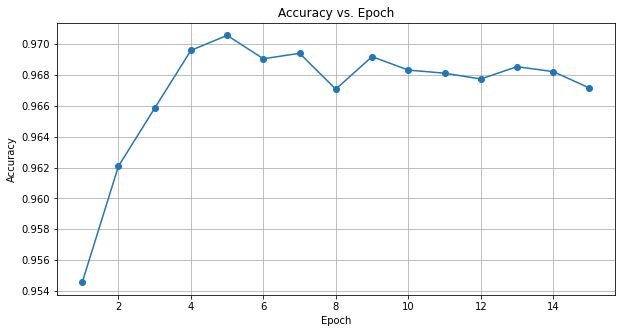

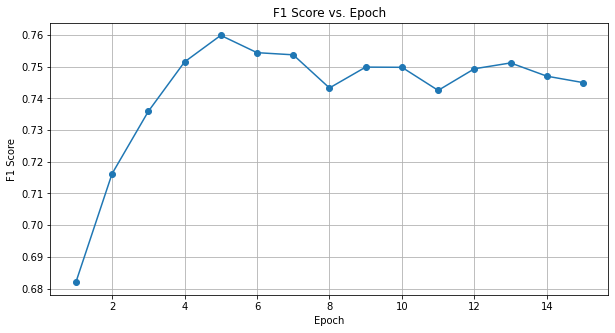

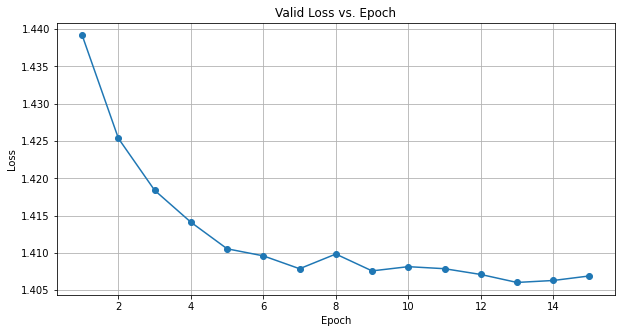

In [143]:
plot_metrics(epoch_accuracy, epoch_f1, epoch_loss)

#### Evaluating LSTM model on test set

In [144]:
# Classifying words in test set and evaluating results
X_test = torch.tensor(test_df['vector'], dtype = torch.float32)
y_test = torch.tensor(test_df['label_encoded'], dtype = torch.long)

lstm_model.eval()
with torch.no_grad():
    label_mask = y_test != 0
    y_test = y_test[label_mask]
    vector_mask = (X_test != 0).all(dim=1)
    X_test = X_test[vector_mask]
    pred = lstm_model(X_test)

    probabilities = F.softmax(pred, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    print(f"Predicted class: {predicted_class}")
    print(f"True class: {y_test}")

    log_probabilities = F.log_softmax(pred, dim=1)
    loss = -log_probabilities.gather(1, y_test.view(-1, 1))
    test_loss = loss.mean().item()
    print(f"Test loss: {test_loss}")

    y_true = decode_labels(y_test)
    y_true = [y_true]

    y_pred = decode_labels(predicted_class)
    y_pred = [y_pred]

    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"F1 Score: {f1}")

    accuracy = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

Predicted class: tensor([8, 8, 4,  ..., 7, 7, 8])
True class: tensor([8, 8, 4,  ..., 7, 8, 8])
Test loss: 0.27423426508903503
F1 Score: 0.7381218467981769
Test Accuracy: 95.66%


### Bidirectional LSTM Model

In [34]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BiLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.bilstm = nn.LSTM(input_size, hidden_size, batch_first = True, bidirectional = True)
        self.fc = nn.Linear(2 * hidden_size, output_size)

    def forward(self, x):
        out, _ = self.bilstm(x)
        logits = self.fc(out)
        return logits

In [289]:
model = BiLSTMClassifier(300, 128, 9)

total_params = sum(param.numel() for param in model.parameters())
print(total_params)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

442633
442633
bilstm.weight_ih_l0 torch.Size([512, 300])
bilstm.weight_hh_l0 torch.Size([512, 128])
bilstm.bias_ih_l0 torch.Size([512])
bilstm.bias_hh_l0 torch.Size([512])
bilstm.weight_ih_l0_reverse torch.Size([512, 300])
bilstm.weight_hh_l0_reverse torch.Size([512, 128])
bilstm.bias_ih_l0_reverse torch.Size([512])
bilstm.bias_hh_l0_reverse torch.Size([512])
fc.weight torch.Size([9, 256])
fc.bias torch.Size([9])


In [146]:
# Define model's input dimension and output dimension
input_dim = w2v.vector_size
hidden_dim = 128
output_dim = len(train_df['label_encoded'].unique())

# Instantiate BiLSTM Model
bilstm_model = BiLSTMClassifier(input_dim, hidden_dim, output_dim)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(bilstm_model.parameters(), lr=0.001)
num_epochs = 50

# Early Stopping
# Patience for this to be confirmed again (if set to 3, might end before improvement)
ES = EarlyStopper(patience = 10)

# Track run time of model training
start_time = time.time()

# Training loop
num_batches = len(train_loader)
print("Starting model training...")
epoch_accuracy = []
epoch_loss = []
epoch_f1 = []
for epoch in range(num_epochs):
    bilstm_model.train()
    train_loss = 0
    for vectors, labels in train_loader:
        # zeroing out <PAD>
        label_mask = labels != 0
        filtered_labels = labels[label_mask]
        vector_mask = (vectors != 0).all(dim=1)
        filtered_vectors = vectors[vector_mask]
        optimizer.zero_grad()
        outputs = bilstm_model(filtered_vectors)

        # Calculate loss
        loss = loss_fn(outputs, filtered_labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= num_batches

    #Calculate validation accuracy
    val_loss = 0
    val_accuracy = []
    f1_score_val = []
    num_val_batches = len(dev_loader)
    size = len(dev_loader.dataset)
    bilstm_model.eval()
    with torch.no_grad():
        for X, y in dev_loader:
            label_mask = y != 0
            filtered_y = y[label_mask]

            vector_mask = (X != 0).all(dim=1)
            filtered_X = X[vector_mask]
            
            val_outputs = bilstm_model(filtered_X)
            val_outputs = F.softmax(val_outputs, dim=1)  # Apply softmax activation
            y_val_pred_classes = np.argmax(val_outputs, axis=1)

            # Transform y back to labels to use in seqeval metrics
            y_true = decode_labels(filtered_y)
            y_true = [y_true]

            # Transform predicted classes back to labels to use in seqeval metrics
            y_pred = decode_labels(y_val_pred_classes)
            y_pred = [y_pred]

            # Calculate accuracy, f1_score and loss
            val_accuracy.append(accuracy_score(y_true, y_pred))
            f1_score_val.append(f1_score(y_true, y_pred, average = "weighted", zero_division = 0))
            val_loss += loss_fn(val_outputs, filtered_y)

    val_accuracy = np.mean(val_accuracy)
    f1_score_val = np.mean(f1_score_val)
    val_loss /= num_val_batches

    epoch_accuracy.append(val_accuracy)
    epoch_f1.append(f1_score_val)
    epoch_loss.append(val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy * 100:.2f}%, F1 Score: {f1_score_val: 4f}')

    if ES.early_stop(f1_score_val):
        print(f"No improvement in F1 score for {ES.patience} epochs. Stopping training.")
        break

end_time = time.time()
run_time = end_time - start_time
print(f"Run time: {run_time: .4f}s")

Starting model training...
Epoch 1/50, Train Loss: 0.1763, Val Loss: 1.4189, Val Accuracy: 96.84%, F1 Score:  0.751732
Epoch 2/50, Train Loss: 0.0864, Val Loss: 1.4064, Val Accuracy: 97.46%, F1 Score:  0.785051
Epoch 3/50, Train Loss: 0.0536, Val Loss: 1.4013, Val Accuracy: 97.60%, F1 Score:  0.793824
Epoch 4/50, Train Loss: 0.0330, Val Loss: 1.3988, Val Accuracy: 97.68%, F1 Score:  0.800050
Epoch 5/50, Train Loss: 0.0216, Val Loss: 1.3980, Val Accuracy: 97.65%, F1 Score:  0.799138
Epoch 6/50, Train Loss: 0.0157, Val Loss: 1.3969, Val Accuracy: 97.71%, F1 Score:  0.802763
Epoch 7/50, Train Loss: 0.0116, Val Loss: 1.3964, Val Accuracy: 97.77%, F1 Score:  0.804623
Epoch 8/50, Train Loss: 0.0095, Val Loss: 1.3966, Val Accuracy: 97.68%, F1 Score:  0.804301
Epoch 9/50, Train Loss: 0.0080, Val Loss: 1.3950, Val Accuracy: 97.78%, F1 Score:  0.806245
Epoch 10/50, Train Loss: 0.0062, Val Loss: 1.3951, Val Accuracy: 97.82%, F1 Score:  0.805672
Epoch 11/50, Train Loss: 0.0061, Val Loss: 1.3955, V

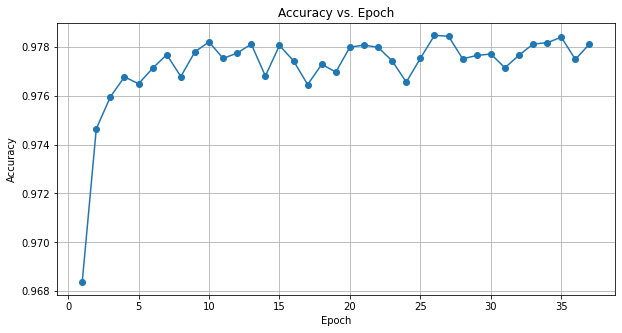

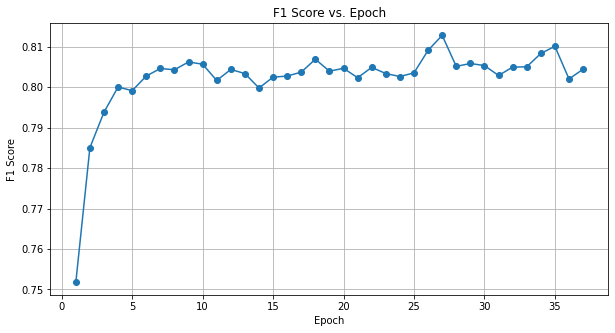

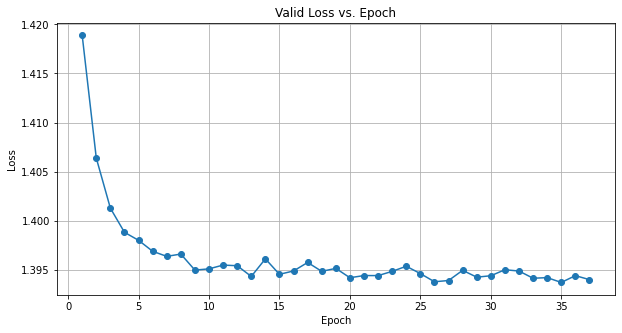

In [147]:
plot_metrics(epoch_accuracy, epoch_f1, epoch_loss)

#### Evaluating Bidirectional LSTM model on test set

In [149]:
# Classifying words in test set and evaluating results
X_test = torch.tensor(test_df['vector'], dtype = torch.float32)
y_test = torch.tensor(test_df['label_encoded'], dtype = torch.long)

bilstm_model.eval()
with torch.no_grad():
    label_mask = y_test != 0
    y_test = y_test[label_mask]
    vector_mask = (X_test != 0).all(dim=1)
    X_test = X_test[vector_mask]
    pred = bilstm_model(X_test)

    probabilities = F.softmax(pred, dim=1)
    predicted_class = torch.argmax(pred, dim=1)
    print(f"Predicted class: {predicted_class}")
    print(f"True class: {y_test}")

    log_probabilities = F.log_softmax(pred, dim=1)
    loss = -log_probabilities.gather(1, y_test.view(-1, 1))
    test_loss = loss.mean().item()
    print(f"Test loss: {test_loss}")

    y_true = decode_labels(y_test)
    y_true = [y_true]

    y_pred = decode_labels(predicted_class)
    y_pred = [y_pred]

    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"F1 Score: {f1}")

    accuracy = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

Predicted class: tensor([8, 8, 4,  ..., 7, 8, 8])
True class: tensor([8, 8, 4,  ..., 7, 8, 8])
Test loss: 0.3502257168292999
F1 Score: 0.819405389154852
Test Accuracy: 96.78%


### Bidirectional LSTM Model with Dropout

In [35]:
class BiLSTMwithDropout(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob):
        super(BiLSTMwithDropout, self).__init__()
        self.hidden_size = hidden_size
        self.bilstm = nn.LSTM(input_size, hidden_size, batch_first = True, bidirectional = True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(2 * hidden_size, output_size)

    def forward(self, x):
        out, _ = self.bilstm(x)
        out = self.dropout(out)
        logits = self.fc(out)
        return logits

In [34]:
import torch
import torch.nn as nn

input_dim = w2v.vector_size
hidden_dim = 128
output_dim = len(train_df['label_encoded'].unique())
BiLSTMwDropout = BiLSTMwithDropout(input_dim, hidden_dim, output_dim, dropout_prob = 0.5)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(BiLSTMwDropout.parameters(), lr=0.001)
num_epochs = 50

# Early Stopping
# Patience for this to be confirmed again (if set to 3, might end before improvement)
ES = EarlyStopper(patience = 10)

# Track run time of model training
start_time = time.time()

# Training loop
num_batches = len(train_loader)
print("Starting model training...")
epoch_accuracy = []
epoch_loss = []
epoch_f1 = []
for epoch in range(num_epochs):
    BiLSTMwDropout.train()
    train_loss = 0
    for vectors, labels in train_loader:
        # zeroing out <PAD>

        label_mask = labels != 0
        filtered_labels = labels[label_mask]
        vector_mask = (vectors != 0).all(dim=1)
        filtered_vectors = vectors[vector_mask]
        optimizer.zero_grad()
        outputs = BiLSTMwDropout(filtered_vectors)

         # Calculate loss
        loss = loss_fn(outputs, filtered_labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= num_batches

    #Calculate validation accuracy
    val_loss = 0
    val_accuracy = []
    f1_score_val = []
    num_val_batches = len(dev_loader)
    size = len(dev_loader.dataset)
    BiLSTMwDropout.eval()
    with torch.no_grad():
        for X, y in dev_loader:
            label_mask = y != 0
            filtered_y = y[label_mask]

            vector_mask = (X != 0).all(dim=1)
            filtered_X = X[vector_mask]
            
            val_outputs = BiLSTMwDropout(filtered_X)
            val_outputs = F.softmax(val_outputs, dim=1)  # Apply softmax activation
            y_val_pred_classes = np.argmax(val_outputs, axis=1)

            # Transform y back to labels to use in seqeval metrics
            y_true = decode_labels(filtered_y)
            y_true = [y_true]

            # Transform predicted classes back to labels to use in seqeval metrics
            y_pred = decode_labels(y_val_pred_classes)
            y_pred = [y_pred]

            # Calculate accuracy, f1_score and loss
            val_accuracy.append(accuracy_score(y_true, y_pred))
            f1_score_val.append(f1_score(y_true, y_pred, average = "weighted", zero_division = 0))
            val_loss += loss_fn(val_outputs, filtered_y)

    val_accuracy = np.mean(val_accuracy)
    f1_score_val = np.mean(f1_score_val)
    val_loss /= num_val_batches

    epoch_accuracy.append(val_accuracy)
    epoch_f1.append(f1_score_val)
    epoch_loss.append(val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy * 100:.2f}%, F1 Score: {f1_score_val: 4f}')

    if ES.early_stop(f1_score_val):
        print(f"No improvement in F1 score for {ES.patience} epochs. Stopping training.")
        break

end_time = time.time()
run_time = end_time - start_time
print(f"Run time: {run_time: .4f}s")

Starting model training...
Epoch 1/50, Train Loss: 0.1965, Val Loss: 1.4239, Val Accuracy: 96.37%, F1 Score:  0.738263
Epoch 2/50, Train Loss: 0.1118, Val Loss: 1.4108, Val Accuracy: 97.15%, F1 Score:  0.770790
Epoch 3/50, Train Loss: 0.0814, Val Loss: 1.4035, Val Accuracy: 97.47%, F1 Score:  0.783416
Epoch 4/50, Train Loss: 0.0636, Val Loss: 1.4011, Val Accuracy: 97.61%, F1 Score:  0.791746
Epoch 5/50, Train Loss: 0.0497, Val Loss: 1.3984, Val Accuracy: 97.78%, F1 Score:  0.800311
Epoch 6/50, Train Loss: 0.0403, Val Loss: 1.3972, Val Accuracy: 97.84%, F1 Score:  0.802253
Epoch 7/50, Train Loss: 0.0337, Val Loss: 1.3969, Val Accuracy: 97.76%, F1 Score:  0.798018
Epoch 8/50, Train Loss: 0.0284, Val Loss: 1.3965, Val Accuracy: 97.83%, F1 Score:  0.805184
Epoch 9/50, Train Loss: 0.0266, Val Loss: 1.3970, Val Accuracy: 97.75%, F1 Score:  0.804026
Epoch 10/50, Train Loss: 0.0224, Val Loss: 1.3966, Val Accuracy: 97.73%, F1 Score:  0.800320
Epoch 11/50, Train Loss: 0.0196, Val Loss: 1.3951, V

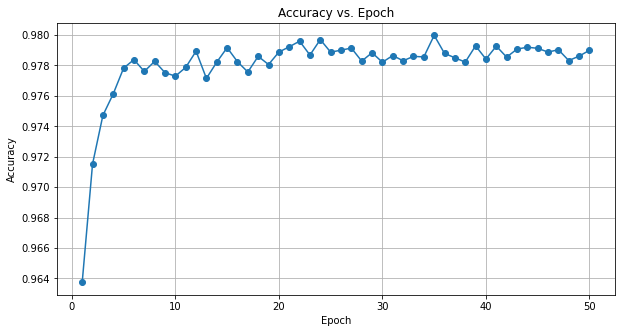

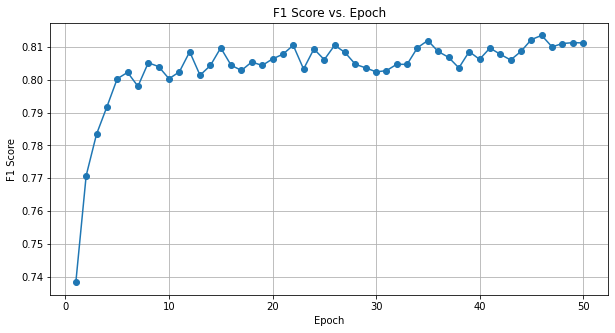

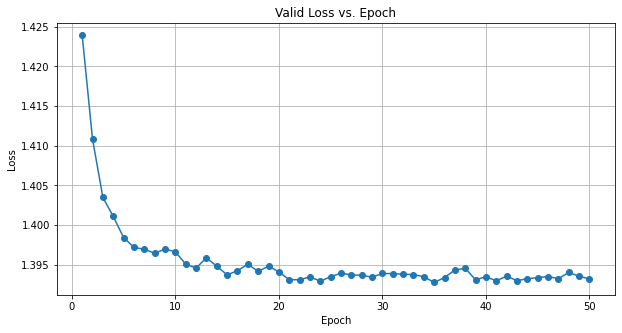

In [37]:
plot_metrics(epoch_accuracy, epoch_f1, epoch_loss)

#### Evaluating Bidirectional LSTM model with Dropout on test set

In [38]:
# Classifying words in test set and evaluating results
X_test = torch.tensor(test_df['vector'], dtype = torch.float32)
y_test = torch.tensor(test_df['label_encoded'], dtype = torch.long)

BiLSTMwDropout.eval()
with torch.no_grad():
    label_mask = y_test != 0
    y_test = y_test[label_mask]
    vector_mask = (X_test != 0).all(dim=1)
    X_test = X_test[vector_mask]
    pred = BiLSTMwDropout(X_test)

    probabilities = F.softmax(pred, dim=1)
    predicted_class = torch.argmax(pred, dim=1)
    print(f"Predicted class: {predicted_class}")
    print(f"True class: {y_test}")

    log_probabilities = F.log_softmax(pred, dim=1)
    loss = -log_probabilities.gather(1, y_test.view(-1, 1))
    test_loss = loss.mean().item()
    print(f"Test loss: {test_loss}")

    y_true = decode_labels(y_test)
    y_true = [y_true]

    y_pred = decode_labels(predicted_class)
    y_pred = [y_pred]

    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"F1 Score: {f1}")

    accuracy = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

<ipython-input-38-ebcd12ce0f0e>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525474122/work/torch/csrc/utils/tensor_new.cpp:233.)
  X_test = torch.tensor(test_df['vector'], dtype = torch.float32)


Predicted class: tensor([8, 8, 4,  ..., 7, 8, 8])
True class: tensor([8, 8, 4,  ..., 7, 8, 8])
Test loss: 0.3347415626049042
F1 Score: 0.8339593683745371
Test Accuracy: 97.00%


### Hyperparameter tuning (Bidirectional LSTM Model with Dropout)

In [36]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


#### Creating smaller dataframes for training and testing

In [239]:
#Training Set

#add 10 of each label
def add_10(label_to_add):
    label_sentences = train_df.loc[train_df["label_encoded"] == label_to_add]
    selected_list = label_sentences["sentence_id"].tolist()
    return selected_list

small_train_data = []

for i in range(1, 9):
    selected_list = add_10(i)
    new_rows = random.sample(selected_list,10)
    small_train_data.extend(new_rows)

print(small_train_data)
small_train_set = set(small_train_data)
remaining_sentences = 200 - len(small_train_set)
print(remaining_sentences)

seed = set_seed(42)
i = 0

while i < remaining_sentences:
    index = random.randint(0, trainSentenceCount)
    if index not in small_train_data:
        small_train_data.append(index)
        i += 1
    else:
        continue

small_train_set = set(small_train_data)
print(len(small_train_set))  

small_train_df = train_df.loc[train_df["sentence_id"].isin(small_train_set)]

[12190, 9852, 9856, 9851, 9853, 9858, 9854, 9855, 9859, 9857, 197, 2960, 9118, 10372, 1332, 4496, 5969, 1999, 5969, 14434, 10363, 10348, 10358, 10345, 10363, 10340, 10348, 10358, 10345, 10340, 11593, 4511, 17, 10077, 14480, 471, 2823, 11055, 9704, 7485, 1404, 6541, 1833, 1970, 12961, 1594, 14272, 2923, 2964, 12653, 13473, 4342, 6657, 12905, 14840, 10300, 5583, 13258, 5489, 7504, 8843, 14905, 13857, 7815, 9353, 11022, 9616, 2203, 4958, 4575, 1562, 8443, 493, 13842, 13010, 6026, 13844, 5722, 142, 1688]
126
200


In [240]:
small_custom_dataset_train = CustomDataset(small_train_df)

dev_index = random.sample(range(1, devSentenceCount), 40)
small_dev_df = dev_df.loc[dev_df["sentence_id"].isin(dev_index)]
small_custom_dataset_dev = CustomDataset(small_dev_df)

print(small_train_df['label_encoded'].value_counts())
print("\n")
print(small_dev_df['label_encoded'].value_counts())

0    21563
8     2648
7      167
6      149
4      138
5       94
3       20
2       11
1       10
Name: label_encoded, dtype: int64


0    4299
8     566
7      34
6      29
4      20
5      12
Name: label_encoded, dtype: int64


In [241]:
small_train_df.head()

,word,label,sentence_id,vector,word_index,label_encoded
2108,Bonn,I-LOC,17,"[0.13867188, 0.19726562, 0.37109375, 0.2001953...",0,4
2109,has,O,17,"[-0.044921875, -0.030395508, 0.0023498535, -0....",1,8
2110,led,O,17,"[0.060302734, 0.28515625, 0.25195312, -0.26367...",2,8
2111,efforts,O,17,"[0.11328125, 0.30664062, -0.10644531, 0.143554...",3,8
2112,to,O,17,"[0.5622607731946327, 0.9620518096803435, 0.574...",4,8


### Bidirectional LSTM model with Dropout

In [245]:
class BiLSTMwithDropout(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob):
        super(BiLSTMwithDropout, self).__init__()
        self.hidden_size = hidden_size
        self.bilstm = nn.LSTM(input_size, hidden_size, batch_first = True, bidirectional = True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(2 * hidden_size, output_size)

    def forward(self, x):
        out, _ = self.bilstm(x)
        out = self.dropout(out)
        logits = self.fc(out)
        return logits

In [246]:
#Define a function to evaluate the model
def evaluate_model(model, data_loader):
    # Calculate validation accuracy
    val_loss = 0
    val_accuracy = []
    f1_score_val = []
    num_val_batches = len(data_loader)
    # size = len(data_loader.dataset)
    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            label_mask = y != 0
            filtered_y = y[label_mask]

            vector_mask = (X != 0).all(dim=1)
            filtered_X = X[vector_mask]
            
            val_outputs = model(filtered_X)
            val_outputs = F.softmax(val_outputs, dim=1)  # Apply softmax activation
            y_val_pred_classes = np.argmax(val_outputs, axis=1)

            # Transform y back to labels to use in seqeval metrics
            y_true = decode_labels(filtered_y)
            y_true = [y_true]

            # Transform predicted classes back to labels to use in seqeval metrics
            y_pred = decode_labels(y_val_pred_classes)
            y_pred = [y_pred]

            # Calculate accuracy, f1_score and loss
            val_accuracy.append(accuracy_score(y_true, y_pred))
            f1_score_val.append(f1_score(y_true, y_pred, average = "weighted", zero_division = 0))
            val_loss += loss_fn(val_outputs, filtered_y)

    val_accuracy = np.mean(val_accuracy)
    f1_score_val = np.mean(f1_score_val)
    val_loss /= num_val_batches

    return val_loss, val_accuracy, f1_score_val

### Hyperparameter tuning for 10 trials

In [250]:
import optuna
from optuna.samplers import TPESampler
import torch
import matplotlib.pyplot as plt
import numpy as np

# Define your model's input dimension and output dimension
input_dim = w2v.vector_size
# hidden_size = 128
output_dim = len(small_train_df['label_encoded'].unique())
# lr = 0.001

# Define a loss function (CrossEntropyLoss for classification)
loss_fn = nn.CrossEntropyLoss()

# Lists to store results
hyperparams_f1 = []
hyperparams_loss = []

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    lr = trial.suggest_float('lr', 0.001, 0.01, log=True)
    # batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])
    number_of_sentences = trial.suggest_int('number_of_sentences', 2, 10)
    hidden_size = trial.suggest_int('hidden_size', 32, 256)
    num_epochs = 50

    BiLSTMwDropout = BiLSTMwithDropout(input_dim, hidden_size, output_dim, dropout_prob = 0.5)

    train_batch = number_of_sentences*train_max_len
    dev_batch = number_of_sentences*dev_max_len

    train_loader = DataLoader(small_custom_dataset_train, batch_size= train_batch, shuffle=False)
    dev_loader = DataLoader(small_custom_dataset_dev, batch_size= dev_batch, shuffle=False)

    optimizer = optim.Adam(BiLSTMwDropout.parameters(), lr=lr)

    num_batches = len(train_loader)
    # Early Stopping
    ES = EarlyStopper(patience=10)

    # Training loop
    total_f1 = []
    total_loss = []

    for epoch in range(num_epochs):
        BiLSTMwDropout.train()
        train_loss = 0
        for vectors, labels in train_loader:
            label_mask = labels != 0
            filtered_labels = labels[label_mask]
            
            vector_mask = (vectors != 0).all(dim=1)
            filtered_vectors = vectors[vector_mask]
            optimizer.zero_grad()
            outputs = BiLSTMwDropout(filtered_vectors)
            # Calculate loss
            loss = loss_fn(outputs, filtered_labels)
            # Backpropagation and optimization
            loss.backward()
            optimizer.step()    
            train_loss += loss.item()
        train_loss /= num_batches

        val_loss, val_accuracy, val_f1 = evaluate_model(BiLSTMwDropout, dev_loader)
        total_f1.append(val_f1)
        total_loss.append(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%, F1 Score: {val_f1:.4f}')

        if ES.early_stop(val_f1):
            print(f"No improvement in F1 score for {ES.patience} epochs. Stopping training.")
            break

    # Append accuracy and loss values for the current trial
    hyperparams_f1.append(np.mean(total_f1))
    hyperparams_loss.append(np.mean(total_loss))
   
    print(f"F1 Score: {np.mean(total_f1)}")
    print(f"Validation loss: {np.mean(total_loss)}\n")

    return np.mean(total_f1)

# Create an Optuna study and optimize hyperparameters
study = optuna.create_study(direction="maximize", sampler=TPESampler())  # maximize F1 score
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_hyperparameters_bilstm_dropout = study.best_params
best_f1_score_bilstm = study.best_value

print("Best Hyperparameters:", best_hyperparameters_bilstm_dropout)

[I 2023-11-09 22:59:37,765] A new study created in memory with name: no-name-0ed99819-2850-4f57-95d4-b65206ecf5f3


Epoch 1/50, Val Loss: 1.6289, Val Accuracy: 77.62%, F1 Score: 0.0000
Epoch 2/50, Val Loss: 1.5836, Val Accuracy: 85.34%, F1 Score: 0.3366
Epoch 3/50, Val Loss: 1.5404, Val Accuracy: 88.64%, F1 Score: 0.5274
Epoch 4/50, Val Loss: 1.5160, Val Accuracy: 89.17%, F1 Score: 0.5395
Epoch 5/50, Val Loss: 1.4990, Val Accuracy: 89.36%, F1 Score: 0.5271
Epoch 6/50, Val Loss: 1.4920, Val Accuracy: 89.69%, F1 Score: 0.5878
Epoch 7/50, Val Loss: 1.4908, Val Accuracy: 89.92%, F1 Score: 0.6068
Epoch 8/50, Val Loss: 1.5002, Val Accuracy: 89.40%, F1 Score: 0.5430
Epoch 9/50, Val Loss: 1.4907, Val Accuracy: 89.40%, F1 Score: 0.5566
Epoch 10/50, Val Loss: 1.4880, Val Accuracy: 88.94%, F1 Score: 0.5351
Epoch 11/50, Val Loss: 1.4877, Val Accuracy: 88.91%, F1 Score: 0.5502
Epoch 12/50, Val Loss: 1.4914, Val Accuracy: 87.90%, F1 Score: 0.5022
Epoch 13/50, Val Loss: 1.4908, Val Accuracy: 88.51%, F1 Score: 0.5286
Epoch 14/50, Val Loss: 1.4859, Val Accuracy: 88.84%, F1 Score: 0.5034
Epoch 15/50, Val Loss: 1.4835

[I 2023-11-09 23:03:15,196] Trial 0 finished with value: 0.4943344485942525 and parameters: {'lr': 0.0016169001322292114, 'number_of_sentences': 2, 'hidden_size': 119}. Best is trial 0 with value: 0.4943344485942525.


Epoch 17/50, Val Loss: 1.4832, Val Accuracy: 88.72%, F1 Score: 0.4632
No improvement in F1 score for 10 epochs. Stopping training.
F1 Score: 0.4943344485942525
Validation loss: 1.5080492496490479

Epoch 1/50, Val Loss: 1.6345, Val Accuracy: 82.91%, F1 Score: 0.0000
Epoch 2/50, Val Loss: 1.5900, Val Accuracy: 82.91%, F1 Score: 0.0000
Epoch 3/50, Val Loss: 1.5532, Val Accuracy: 84.29%, F1 Score: 0.1564
Epoch 4/50, Val Loss: 1.5243, Val Accuracy: 87.33%, F1 Score: 0.2810
Epoch 5/50, Val Loss: 1.5039, Val Accuracy: 89.94%, F1 Score: 0.4442
Epoch 6/50, Val Loss: 1.4902, Val Accuracy: 91.80%, F1 Score: 0.5320
Epoch 7/50, Val Loss: 1.4831, Val Accuracy: 91.93%, F1 Score: 0.5928
Epoch 8/50, Val Loss: 1.4702, Val Accuracy: 92.76%, F1 Score: 0.6155
Epoch 9/50, Val Loss: 1.4648, Val Accuracy: 92.57%, F1 Score: 0.5998
Epoch 10/50, Val Loss: 1.4587, Val Accuracy: 93.25%, F1 Score: 0.6403
Epoch 11/50, Val Loss: 1.4569, Val Accuracy: 93.34%, F1 Score: 0.6580
Epoch 12/50, Val Loss: 1.4565, Val Accurac

[I 2023-11-09 23:12:05,287] Trial 1 finished with value: 0.6090649451107182 and parameters: {'lr': 0.002671782588486447, 'number_of_sentences': 8, 'hidden_size': 50}. Best is trial 1 with value: 0.6090649451107182.


Epoch 50/50, Val Loss: 1.4394, Val Accuracy: 93.92%, F1 Score: 0.6803
F1 Score: 0.6090649451107182
Validation loss: 1.4594907760620117

Epoch 1/50, Val Loss: 1.6113, Val Accuracy: 81.98%, F1 Score: 0.0000
Epoch 2/50, Val Loss: 1.5690, Val Accuracy: 84.98%, F1 Score: 0.1947
Epoch 3/50, Val Loss: 1.5180, Val Accuracy: 91.39%, F1 Score: 0.5336
Epoch 4/50, Val Loss: 1.4922, Val Accuracy: 92.97%, F1 Score: 0.6539
Epoch 5/50, Val Loss: 1.4720, Val Accuracy: 93.08%, F1 Score: 0.7133
Epoch 6/50, Val Loss: 1.4657, Val Accuracy: 93.32%, F1 Score: 0.6839
Epoch 7/50, Val Loss: 1.4609, Val Accuracy: 93.25%, F1 Score: 0.6945
Epoch 8/50, Val Loss: 1.4579, Val Accuracy: 92.27%, F1 Score: 0.6907
Epoch 9/50, Val Loss: 1.4611, Val Accuracy: 91.77%, F1 Score: 0.6160
Epoch 10/50, Val Loss: 1.4569, Val Accuracy: 92.48%, F1 Score: 0.6301
Epoch 11/50, Val Loss: 1.4588, Val Accuracy: 91.54%, F1 Score: 0.6111
Epoch 12/50, Val Loss: 1.4575, Val Accuracy: 91.96%, F1 Score: 0.6667
Epoch 13/50, Val Loss: 1.4501, Va

[I 2023-11-09 23:14:59,009] Trial 2 finished with value: 0.5730455071223468 and parameters: {'lr': 0.0025560556365748365, 'number_of_sentences': 4, 'hidden_size': 113}. Best is trial 1 with value: 0.6090649451107182.


Epoch 15/50, Val Loss: 1.4519, Val Accuracy: 91.81%, F1 Score: 0.6140
No improvement in F1 score for 10 epochs. Stopping training.
F1 Score: 0.5730455071223468
Validation loss: 1.4822698831558228

Epoch 1/50, Val Loss: 1.6059, Val Accuracy: 80.89%, F1 Score: 0.0000
Epoch 2/50, Val Loss: 1.5777, Val Accuracy: 81.61%, F1 Score: 0.0755
Epoch 3/50, Val Loss: 1.5365, Val Accuracy: 89.27%, F1 Score: 0.4818
Epoch 4/50, Val Loss: 1.5010, Val Accuracy: 90.70%, F1 Score: 0.5822
Epoch 5/50, Val Loss: 1.4871, Val Accuracy: 90.66%, F1 Score: 0.6580
Epoch 6/50, Val Loss: 1.4792, Val Accuracy: 90.32%, F1 Score: 0.6196
Epoch 7/50, Val Loss: 1.4724, Val Accuracy: 91.23%, F1 Score: 0.6562
Epoch 8/50, Val Loss: 1.4777, Val Accuracy: 90.25%, F1 Score: 0.5577
Epoch 9/50, Val Loss: 1.4760, Val Accuracy: 90.29%, F1 Score: 0.5782
Epoch 10/50, Val Loss: 1.4724, Val Accuracy: 90.82%, F1 Score: 0.5804
Epoch 11/50, Val Loss: 1.4696, Val Accuracy: 90.59%, F1 Score: 0.6333
Epoch 12/50, Val Loss: 1.4637, Val Accurac

[I 2023-11-09 23:23:47,376] Trial 3 finished with value: 0.6233904814655175 and parameters: {'lr': 0.0034936171922201106, 'number_of_sentences': 6, 'hidden_size': 119}. Best is trial 3 with value: 0.6233904814655175.


Epoch 45/50, Val Loss: 1.4449, Val Accuracy: 92.68%, F1 Score: 0.6470
No improvement in F1 score for 10 epochs. Stopping training.
F1 Score: 0.6233904814655175
Validation loss: 1.4628732204437256

Epoch 1/50, Val Loss: 1.6184, Val Accuracy: 79.87%, F1 Score: 0.0000
Epoch 2/50, Val Loss: 1.5803, Val Accuracy: 88.65%, F1 Score: 0.2959
Epoch 3/50, Val Loss: 1.5162, Val Accuracy: 92.84%, F1 Score: 0.5201
Epoch 4/50, Val Loss: 1.4823, Val Accuracy: 93.50%, F1 Score: 0.5792
Epoch 5/50, Val Loss: 1.4673, Val Accuracy: 94.13%, F1 Score: 0.6547
Epoch 6/50, Val Loss: 1.4615, Val Accuracy: 94.45%, F1 Score: 0.6472
Epoch 7/50, Val Loss: 1.4532, Val Accuracy: 94.13%, F1 Score: 0.6753
Epoch 8/50, Val Loss: 1.4509, Val Accuracy: 93.87%, F1 Score: 0.6566
Epoch 9/50, Val Loss: 1.4476, Val Accuracy: 93.75%, F1 Score: 0.6468
Epoch 10/50, Val Loss: 1.4489, Val Accuracy: 93.50%, F1 Score: 0.6639
Epoch 11/50, Val Loss: 1.4467, Val Accuracy: 93.73%, F1 Score: 0.6143
Epoch 12/50, Val Loss: 1.4501, Val Accurac

[I 2023-11-09 23:30:07,733] Trial 4 finished with value: 0.5657800623857047 and parameters: {'lr': 0.0015775506702219771, 'number_of_sentences': 3, 'hidden_size': 216}. Best is trial 3 with value: 0.6233904814655175.


Epoch 17/50, Val Loss: 1.4348, Val Accuracy: 93.95%, F1 Score: 0.6008
No improvement in F1 score for 10 epochs. Stopping training.
F1 Score: 0.5657800623857047
Validation loss: 1.4720112085342407

Epoch 1/50, Val Loss: 1.6090, Val Accuracy: 82.48%, F1 Score: 0.0000
Epoch 2/50, Val Loss: 1.5606, Val Accuracy: 85.15%, F1 Score: 0.2045
Epoch 3/50, Val Loss: 1.5206, Val Accuracy: 88.42%, F1 Score: 0.3160
Epoch 4/50, Val Loss: 1.4948, Val Accuracy: 91.37%, F1 Score: 0.5629
Epoch 5/50, Val Loss: 1.4799, Val Accuracy: 91.45%, F1 Score: 0.5442
Epoch 6/50, Val Loss: 1.4724, Val Accuracy: 91.65%, F1 Score: 0.5517
Epoch 7/50, Val Loss: 1.4664, Val Accuracy: 91.78%, F1 Score: 0.5370
Epoch 8/50, Val Loss: 1.4611, Val Accuracy: 91.97%, F1 Score: 0.5966
Epoch 9/50, Val Loss: 1.4563, Val Accuracy: 92.47%, F1 Score: 0.5883
Epoch 10/50, Val Loss: 1.4486, Val Accuracy: 93.92%, F1 Score: 0.6929
Epoch 11/50, Val Loss: 1.4480, Val Accuracy: 93.26%, F1 Score: 0.6964
Epoch 12/50, Val Loss: 1.4475, Val Accurac

[I 2023-11-09 23:39:11,907] Trial 5 finished with value: 0.6076706462463541 and parameters: {'lr': 0.004119624880646622, 'number_of_sentences': 7, 'hidden_size': 52}. Best is trial 3 with value: 0.6233904814655175.


Epoch 1/50, Val Loss: 1.6193, Val Accuracy: 80.89%, F1 Score: 0.0000
Epoch 2/50, Val Loss: 1.5669, Val Accuracy: 84.05%, F1 Score: 0.1660
Epoch 3/50, Val Loss: 1.5215, Val Accuracy: 90.67%, F1 Score: 0.5738
Epoch 4/50, Val Loss: 1.4956, Val Accuracy: 91.60%, F1 Score: 0.5949
Epoch 5/50, Val Loss: 1.4827, Val Accuracy: 91.04%, F1 Score: 0.6476
Epoch 6/50, Val Loss: 1.4735, Val Accuracy: 91.19%, F1 Score: 0.6112
Epoch 7/50, Val Loss: 1.4883, Val Accuracy: 90.10%, F1 Score: 0.5905
Epoch 8/50, Val Loss: 1.4840, Val Accuracy: 89.63%, F1 Score: 0.5143
Epoch 9/50, Val Loss: 1.4731, Val Accuracy: 90.12%, F1 Score: 0.5523
Epoch 10/50, Val Loss: 1.4634, Val Accuracy: 90.85%, F1 Score: 0.6092
Epoch 11/50, Val Loss: 1.4601, Val Accuracy: 91.88%, F1 Score: 0.6011
Epoch 12/50, Val Loss: 1.4554, Val Accuracy: 91.49%, F1 Score: 0.6604
Epoch 13/50, Val Loss: 1.4593, Val Accuracy: 91.84%, F1 Score: 0.6632
Epoch 14/50, Val Loss: 1.4516, Val Accuracy: 92.12%, F1 Score: 0.6426
Epoch 15/50, Val Loss: 1.4521

[I 2023-11-09 23:57:06,776] Trial 6 finished with value: 0.6044902006857696 and parameters: {'lr': 0.0030814383544445077, 'number_of_sentences': 6, 'hidden_size': 190}. Best is trial 3 with value: 0.6233904814655175.


Epoch 34/50, Val Loss: 1.4528, Val Accuracy: 91.77%, F1 Score: 0.6288
No improvement in F1 score for 10 epochs. Stopping training.
F1 Score: 0.6044902006857696
Validation loss: 1.4673117399215698

Epoch 1/50, Val Loss: 1.6383, Val Accuracy: 81.98%, F1 Score: 0.0000
Epoch 2/50, Val Loss: 1.6046, Val Accuracy: 81.98%, F1 Score: 0.0000
Epoch 3/50, Val Loss: 1.5755, Val Accuracy: 84.84%, F1 Score: 0.1869
Epoch 4/50, Val Loss: 1.5413, Val Accuracy: 88.95%, F1 Score: 0.3728
Epoch 5/50, Val Loss: 1.5180, Val Accuracy: 90.45%, F1 Score: 0.4887
Epoch 6/50, Val Loss: 1.5019, Val Accuracy: 92.37%, F1 Score: 0.5925
Epoch 7/50, Val Loss: 1.4917, Val Accuracy: 93.46%, F1 Score: 0.6406
Epoch 8/50, Val Loss: 1.4818, Val Accuracy: 93.50%, F1 Score: 0.6163
Epoch 9/50, Val Loss: 1.4743, Val Accuracy: 93.27%, F1 Score: 0.6257
Epoch 10/50, Val Loss: 1.4676, Val Accuracy: 93.85%, F1 Score: 0.6632
Epoch 11/50, Val Loss: 1.4629, Val Accuracy: 93.89%, F1 Score: 0.6457
Epoch 12/50, Val Loss: 1.4632, Val Accurac

[I 2023-11-10 00:08:01,380] Trial 7 finished with value: 0.5506924254397197 and parameters: {'lr': 0.0012304799137549344, 'number_of_sentences': 4, 'hidden_size': 69}. Best is trial 3 with value: 0.6233904814655175.


Epoch 24/50, Val Loss: 1.4523, Val Accuracy: 92.47%, F1 Score: 0.6399
No improvement in F1 score for 10 epochs. Stopping training.
F1 Score: 0.5506924254397197
Validation loss: 1.4868682622909546

Epoch 1/50, Val Loss: 1.6302, Val Accuracy: 79.87%, F1 Score: 0.0000
Epoch 2/50, Val Loss: 1.6057, Val Accuracy: 84.41%, F1 Score: 0.1173
Epoch 3/50, Val Loss: 1.5573, Val Accuracy: 89.77%, F1 Score: 0.3835
Epoch 4/50, Val Loss: 1.5160, Val Accuracy: 94.25%, F1 Score: 0.6455
Epoch 5/50, Val Loss: 1.4912, Val Accuracy: 94.44%, F1 Score: 0.6424
Epoch 6/50, Val Loss: 1.4740, Val Accuracy: 94.44%, F1 Score: 0.6456
Epoch 7/50, Val Loss: 1.4618, Val Accuracy: 95.06%, F1 Score: 0.7164
Epoch 8/50, Val Loss: 1.4636, Val Accuracy: 94.17%, F1 Score: 0.6658
Epoch 9/50, Val Loss: 1.4533, Val Accuracy: 94.70%, F1 Score: 0.7117
Epoch 10/50, Val Loss: 1.4478, Val Accuracy: 94.77%, F1 Score: 0.7109
Epoch 11/50, Val Loss: 1.4490, Val Accuracy: 94.60%, F1 Score: 0.6848
Epoch 12/50, Val Loss: 1.4470, Val Accurac

[I 2023-11-10 00:18:41,524] Trial 8 finished with value: 0.5724116399806675 and parameters: {'lr': 0.0015015439626213799, 'number_of_sentences': 3, 'hidden_size': 94}. Best is trial 3 with value: 0.6233904814655175.


Epoch 17/50, Val Loss: 1.4439, Val Accuracy: 93.24%, F1 Score: 0.6086
No improvement in F1 score for 10 epochs. Stopping training.
F1 Score: 0.5724116399806675
Validation loss: 1.4841156005859375

Epoch 1/50, Val Loss: 1.6725, Val Accuracy: 79.60%, F1 Score: 0.0000
Epoch 2/50, Val Loss: 1.6271, Val Accuracy: 79.60%, F1 Score: 0.0000
Epoch 3/50, Val Loss: 1.5975, Val Accuracy: 79.76%, F1 Score: 0.0171
Epoch 4/50, Val Loss: 1.5757, Val Accuracy: 83.94%, F1 Score: 0.2530
Epoch 5/50, Val Loss: 1.5486, Val Accuracy: 86.50%, F1 Score: 0.4590
Epoch 6/50, Val Loss: 1.5338, Val Accuracy: 87.41%, F1 Score: 0.5480
Epoch 7/50, Val Loss: 1.5162, Val Accuracy: 88.20%, F1 Score: 0.5696
Epoch 8/50, Val Loss: 1.5068, Val Accuracy: 89.69%, F1 Score: 0.6049
Epoch 9/50, Val Loss: 1.4956, Val Accuracy: 91.60%, F1 Score: 0.6766
Epoch 10/50, Val Loss: 1.4885, Val Accuracy: 91.76%, F1 Score: 0.7008
Epoch 11/50, Val Loss: 1.4884, Val Accuracy: 90.75%, F1 Score: 0.6533
Epoch 12/50, Val Loss: 1.4935, Val Accurac

[I 2023-11-10 00:30:35,463] Trial 9 finished with value: 0.5585747038007635 and parameters: {'lr': 0.0016298841230761327, 'number_of_sentences': 9, 'hidden_size': 110}. Best is trial 3 with value: 0.6233904814655175.


Best Hyperparameters: {'lr': 0.0034936171922201106, 'number_of_sentences': 6, 'hidden_size': 119}


#### Graph of F1 score and loss

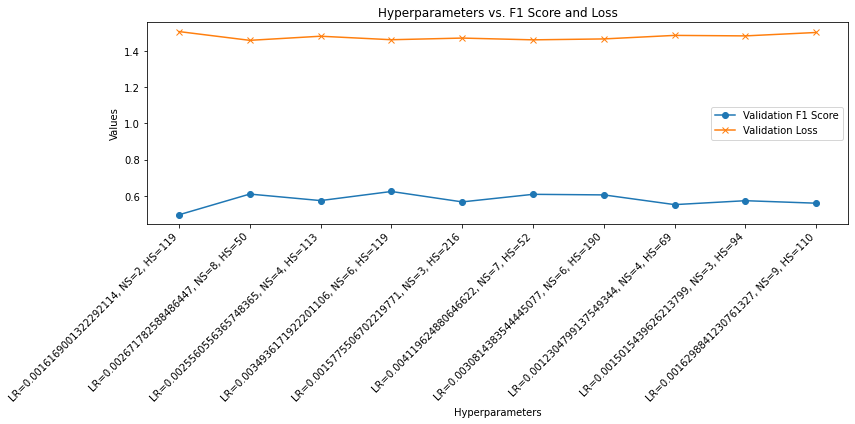

In [253]:
# Create a plot of hyperparameters vs. f1 score and loss
plt.figure(figsize=(12, 6))
x = range(len(hyperparams_f1))
plt.plot(x, hyperparams_f1, label='Validation F1 Score', marker='o')
plt.plot(x, hyperparams_loss, label='Validation Loss', marker='x')

# Labeling the x-axis with hyperparameter values
hyperparameter_labels = [f"LR={study.trials[i].params['lr']}, NS={(study.trials[i].params['number_of_sentences'])}, HS={study.trials[i].params['hidden_size']}" for i in range(len(study.trials))]
plt.xticks(x, hyperparameter_labels, rotation=45, ha='right')

plt.title("Hyperparameters vs. F1 Score and Loss")
plt.xlabel("Hyperparameters")
plt.ylabel("Values")
plt.legend()
plt.tight_layout()
plt.show()


#### Using optimal hyperparamters to train model

In [267]:
print("Training with best hyperparameters:", best_hyperparameters_bilstm_dropout)

number_of_sentences = best_hyperparameters_bilstm_dropout['number_of_sentences']
custom_dataset_train = CustomDataset(train_df)
train_loader = DataLoader(custom_dataset_train, batch_size=number_of_sentences * train_max_len, shuffle=False)

custom_dataset_dev = CustomDataset(dev_df)
dev_loader = DataLoader(custom_dataset_dev, batch_size=number_of_sentences * dev_max_len, shuffle=False)

# Define model's parameters
input_dim = w2v.vector_size
hidden_dim = best_hyperparameters_bilstm_dropout['hidden_size']
output_dim = len(train_df['label_encoded'].unique())
lr = best_hyperparameters_bilstm_dropout['lr']

# Instantiate BiLSTM Model
bilstm_model = BiLSTMwithDropout(input_dim, hidden_dim, output_dim, dropout_prob=0.5)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(bilstm_model.parameters(), lr=lr)
num_epochs = 50

# Early Stopping
# Patience for this to be confirmed again (if set to 3, might end before improvement)
ES = EarlyStopper(patience = 10)

# Track run time of model training
start_time = time.time()

# Training loop
num_batches = len(train_loader)
print("Starting model training...")
epoch_accuracy = []
epoch_loss = []
epoch_f1 = []
for epoch in range(num_epochs):
    bilstm_model.train()
    train_loss = 0
    for vectors, labels in train_loader:
        # zeroing out <PAD>
        label_mask = labels != 0
        filtered_labels = labels[label_mask]
        vector_mask = (vectors != 0).all(dim=1)
        filtered_vectors = vectors[vector_mask]
        optimizer.zero_grad()
        outputs = bilstm_model(filtered_vectors)

        # Calculate loss
        loss = loss_fn(outputs, filtered_labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= num_batches

    #Calculate validation accuracy
    val_loss = 0
    val_accuracy = []
    f1_score_val = []
    num_val_batches = len(dev_loader)
    size = len(dev_loader.dataset)
    bilstm_model.eval()
    with torch.no_grad():
        for X, y in dev_loader:
            label_mask = y != 0
            filtered_y = y[label_mask]

            vector_mask = (X != 0).all(dim=1)
            filtered_X = X[vector_mask]
            
            val_outputs = bilstm_model(filtered_X)
            val_outputs = F.softmax(val_outputs, dim=1)  # Apply softmax activation
            y_val_pred_classes = np.argmax(val_outputs, axis=1)

            # Transform y back to labels to use in seqeval metrics
            y_true = decode_labels(filtered_y)
            y_true = [y_true]

            # Transform predicted classes back to labels to use in seqeval metrics
            y_pred = decode_labels(y_val_pred_classes)
            y_pred = [y_pred]

            # Calculate accuracy, f1_score and loss
            val_accuracy.append(accuracy_score(y_true, y_pred))
            f1_score_val.append(f1_score(y_true, y_pred, average = "weighted", zero_division = 0))
            val_loss += loss_fn(val_outputs, filtered_y)

    val_accuracy = np.mean(val_accuracy)
    f1_score_val = np.mean(f1_score_val)
    val_loss /= num_val_batches

    epoch_accuracy.append(val_accuracy)
    epoch_f1.append(f1_score_val)
    epoch_loss.append(val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy * 100:.2f}%, F1 Score: {f1_score_val: 4f}')

    if ES.early_stop(f1_score_val):
        print(f"No improvement in F1 score for {ES.patience} epochs. Stopping training.")
        break

end_time = time.time()
run_time = end_time - start_time
print(f"Run time: {run_time: .4f}s")

Training with best hyperparameters: {'lr': 0.0034936171922201106, 'number_of_sentences': 6, 'hidden_size': 119}
Starting model training...
Epoch 1/50, Train Loss: 0.2031, Val Loss: 1.4215, Val Accuracy: 97.15%, F1 Score:  0.832933
Epoch 2/50, Train Loss: 0.1178, Val Loss: 1.4110, Val Accuracy: 97.55%, F1 Score:  0.852264
Epoch 3/50, Train Loss: 0.0937, Val Loss: 1.4042, Val Accuracy: 97.84%, F1 Score:  0.869018
Epoch 4/50, Train Loss: 0.0760, Val Loss: 1.4015, Val Accuracy: 97.91%, F1 Score:  0.869283
Epoch 5/50, Train Loss: 0.0672, Val Loss: 1.3987, Val Accuracy: 97.89%, F1 Score:  0.867577
Epoch 6/50, Train Loss: 0.0592, Val Loss: 1.3977, Val Accuracy: 97.88%, F1 Score:  0.867261
Epoch 7/50, Train Loss: 0.0547, Val Loss: 1.3962, Val Accuracy: 97.96%, F1 Score:  0.872005
Epoch 8/50, Train Loss: 0.0517, Val Loss: 1.3968, Val Accuracy: 97.86%, F1 Score:  0.868966
Epoch 9/50, Train Loss: 0.0455, Val Loss: 1.3958, Val Accuracy: 97.96%, F1 Score:  0.874304
Epoch 10/50, Train Loss: 0.0444, 

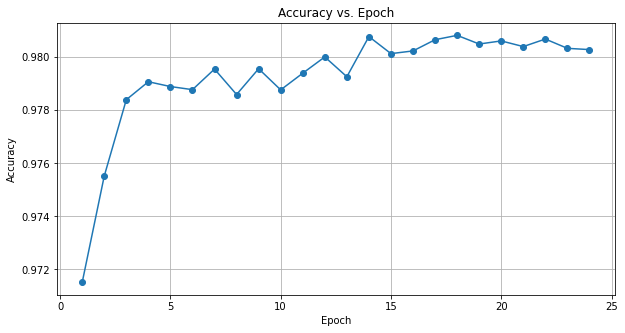

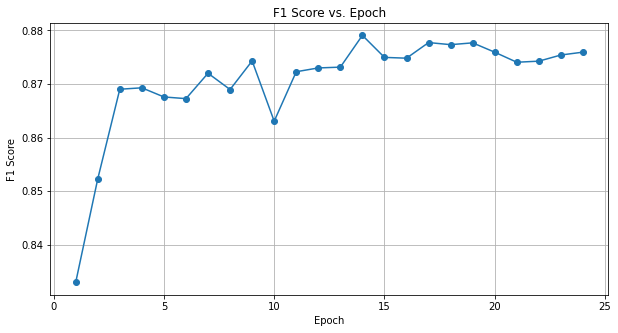

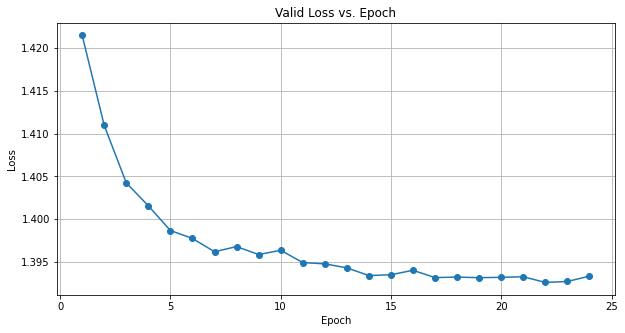

In [268]:
plot_metrics(epoch_accuracy, epoch_f1, epoch_loss)

#### Evaluating optimal hyperparameters on test set

In [269]:
X_test = torch.tensor(test_df['vector'], dtype = torch.float32)
y_test = torch.tensor(test_df['label_encoded'], dtype = torch.long)

bilstm_model.eval()
with torch.no_grad():
    label_mask = y_test != 0
    y_test = y_test[label_mask]
    vector_mask = (X_test != 0).all(dim=1)
    X_test = X_test[vector_mask]
    pred = bilstm_model(X_test)

probabilities = F.softmax(pred, dim=1)
predicted_class = torch.argmax(pred, dim=1)
print(f"Predicted class: {predicted_class}")
print(f"True class: {y_test}")

log_probabilities = F.log_softmax(pred, dim=1)
loss = -log_probabilities.gather(1, y_test.view(-1, 1))
test_loss = loss.mean().item()
print(f"Test loss: {test_loss}")

y_true = decode_labels(y_test)
y_true = [y_true]

y_pred = decode_labels(predicted_class)
y_pred = [y_pred]

f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1}")

accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Predicted class: tensor([8, 8, 4,  ..., 7, 8, 8])
True class: tensor([8, 8, 4,  ..., 7, 8, 8])
Test loss: 0.20715296268463135
F1 Score: 0.8283925801744163
Test Accuracy: 96.98%


In [ ]:
torch.save(BiLSTMwithDropout.state_dict(), "best_hyperparameters_bilstm_dropout")

#### Alternative hyperparamter tuning using Grid Search

In [ ]:
#Grid Search for Optimal Parameters

# #Define a function to evaluate the model
# def evaluate_model(model, data_loader):
#     # Calculate validation accuracy
#     val_loss = 0
#     val_accuracy = []
#     f1_score_val = []
#     num_val_batches = len(data_loader)
#     size = len(data_loader.dataset)
#     model.eval()
#     with torch.no_grad():
#         for X, y in data_loader:
#             label_mask = y != 0
#             filtered_y = y[label_mask]

#             vector_mask = (X != 0).all(dim=1)
#             filtered_X = X[vector_mask]
            
#             val_outputs = model(filtered_X)
#             val_outputs = F.softmax(val_outputs, dim=1)  # Apply softmax activation
#             y_val_pred_classes = np.argmax(val_outputs, axis=1)

#             # Transform y back to labels to use in seqeval metrics
#             y_true = decode_labels(filtered_y)
#             y_true = [y_true]

#             # Transform predicted classes back to labels to use in seqeval metrics
#             y_pred = decode_labels(y_val_pred_classes)
#             y_pred = [y_pred]

#             # Calculate accuracy, f1_score and loss
#             val_accuracy.append(accuracy_score(y_true, y_pred))
#             f1_score_val.append(f1_score(y_true, y_pred, average = "weighted", zero_division = 0))
#             val_loss += loss_fn(val_outputs, filtered_y)

#     val_accuracy = np.mean(val_accuracy)
#     f1_score_val = np.mean(f1_score_val)
#     val_loss /= num_val_batches

#     return val_loss, val_accuracy, f1_score_val

# # Define your model's input dimension and output dimension
# input_dim = w2v.vector_size
# hidden_dim = 128
# output_dim = 9

# # Define a loss function (CrossEntropyLoss for classification) and an optimizer (e.g., Adam)
# loss_fn = nn.CrossEntropyLoss()

# # Define a hyperparameter grid
# param_grid = {
#     'lr': [0.001, 0.05, 0.01],
#     'batch_size': [2, 3, 4],
#     'num_epochs': [50],
# }

# best_hyperparameters = None
# best_f1_score = 0
# hyperparams_accuracy = []
# hyperparams_loss = []
# for hyperparameters in ParameterGrid(param_grid):
#     print(f"Training with hyperparameters: {hyperparameters}")
#     model = BiLSTMwithDropout(input_dim, hidden_dim, output_dim, dropout_prob=0.5)
#     optimizer = optim.Adam(model.parameters(), lr=hyperparameters['lr'])

#     train_loader = DataLoader(small_custom_dataset_train, batch_size=hyperparameters['batch_size']*train_max_len, shuffle=False)
#     dev_loader = DataLoader(small_custom_dataset_dev, batch_size=hyperparameters['batch_size']*dev_max_len, shuffle=False)

#     #Early Stopping
#     ES = EarlyStopper(patience = 10)

#     # Training loop
#     print("Starting model training...")
#     num_batches = len(train_loader)
#     total_f1 = []
#     total_loss = []
#     for epoch in range(hyperparameters['num_epochs']):
#         model.train()
#         loss_ = []
#         train_loss = 0
#         for vectors, labels in train_loader:
#             label_mask = labels != 0
#             filtered_labels = labels[label_mask]
            
#             vector_mask = (vectors != 0).all(dim=1)
#             filtered_vectors = vectors[vector_mask]
#             optimizer.zero_grad()
#             outputs = model(filtered_vectors)

#             # Calculate loss
#             loss = loss_fn(outputs, filtered_labels)
#             loss_.append(loss.item())

#             # Backpropagation and optimization
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()
#         train_loss /= num_batches

#         val_loss, val_accuracy, val_f1 = evaluate_model(model, dev_loader)
#         total_f1.append(val_f1)
#         total_loss.append(val_loss)

#         print(f'Epoch {epoch+1}/{hyperparameters["num_epochs"]}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%, F1 Score: {val_f1:.4f}')

#         if ES.early_stop(val_f1):
#             print(f"No improvement in F1 score for {ES.patience} epochs. Stopping training.")
#             break

#     hyperparams_accuracy.append(np.mean(total_f1))
#     hyperparams_loss.append(np.mean(total_loss))
    
#     if np.mean(total_f1) > best_f1_score:
#             # Update the best hyperparameters
#             best_hyperparameters = hyperparameters
#             best_f1_score = np.mean(total_f1)
#             print(f'Found new best hyperparameters:', best_hyperparameters)

# print("Best Hyperparameters:", best_hyperparameters)